In [1]:
from pathlib import Path
import argparse

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import tables
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from iminuit import Minuit
from iminuit.cost import LeastSquares

Plot styles

In [3]:
# Jupyter notebook
%matplotlib inline

# Shell
#matplotlib.use('Agg')

plt.style.use(hep.style.CMS)

Define functions that may be fit to the rates

In [4]:
def sg(x, peak, mean, cap_sigma):
    return peak*np.exp(-(x-mean)**2/(2*cap_sigma**2))

In [5]:
def sg_const(x, peak, mean, cap_sigma, constant):
    return sg(x, peak, mean, cap_sigma) + constant

Each function needs a mapping from string given as a parameter, and also a set of initial conditions

In [6]:
FIT_FUNCTIONS = {
    'sg':       {'handle': sg,       'initial_values': {'peak': 1e-4, 'mean': 0, 'cap_sigma': 0.3}},
    'sg_const': {'handle': sg_const, 'initial_values': {'peak': 1e-4, 'mean': 0, 'cap_sigma': 0.3, 'constant': 0}}
}

In [7]:
files = ['7525_2110302352_2110310014.hd5']
luminometer = 'pltlumizero'
fit = 'sg'
calibrate_beam_current = True
pdf = True

In [8]:
for filename in files:
    outpath = f'output/{Path(filename).stem}' # Save output to this folder
    Path(outpath).mkdir(parents=True, exist_ok=True) # Create output folder if not existing already
    with tables.open_file(filename, 'r') as f:
        general_info = pd.DataFrame([list(f.root.vdmscan[0])], columns=f.root.vdmscan.colnames) # Get first row of table "vdmscan" to save scan conditions that are constant through the scan
        general_info['ip'] = general_info['ip'].apply(lambda ip: [i for i,b in enumerate(bin(ip)[::-1]) if b == '1']) # Binary to dec to list all scanning IPs (scan in IP n iff bit n == 1)
        general_info['energy'] = f.root.beam[0]['egev']
        general_info = general_info[['fillnum', 'runnum', 'timestampsec', 'energy', 'ip', 'bstar5', 'xingHmurad']]
        general_info.to_csv(f'{outpath}/scan.csv', index=False) # Save this set of conditions to file
        print('General scan info\n', general_info.to_string(index=False))

        # Associate timestamps to scan plane - scan point -pairs
        scan = pd.DataFrame()
        scan['timestampsec'] = [r['timestampsec'] for r in f.root.vdmscan.where('stat == "ACQUIRING"')]
        scan['sep'] = [r['sep'] for r in f.root.vdmscan.where('stat == "ACQUIRING"')]
        scan['nominal_sep_plane'] = [r['nominal_sep_plane'].decode('utf-8') for r in f.root.vdmscan.where('stat == "ACQUIRING"')] # Decode is needed for values of type string
        scan = scan.groupby(['nominal_sep_plane', 'sep']).agg(min_time=('timestampsec', np.min), max_time=('timestampsec', np.max)) # Get min and max for each plane - sep pair
        scan.reset_index(inplace=True) # Return values used to group to normal columns
        print('\nScanpoints and timestamps\n', scan.head())

        collidable = np.nonzero(f.root.beam[0]['collidable'])[0] # Indices of colliding bunches (0-indexed), np.nonzero returns 2 arrays where the first contains indices
        filled = np.nonzero(np.logical_or(f.root.beam[0]['bxconfig1'], f.root.beam[0]['bxconfig2']))[0]        

        # Go through each scan point and get rate and beam currect values for each colliding bunch
        data = pd.DataFrame()
        for p, plane in enumerate(scan.nominal_sep_plane.unique()):
            for sep in scan.sep.unique():
                new = pd.DataFrame()
                new['bcid'] = collidable + 1 # From 0-indexed to 1-indexed
                period_of_scanpoint = f'(timestampsec > {scan.min_time[(scan.nominal_sep_plane == plane) & (scan.sep == sep)].item()}) & (timestampsec <= {scan.max_time[(scan.nominal_sep_plane == plane) & (scan.sep == sep)].item()})'
                r = np.array([r['bxraw'][collidable] for r in f.root[luminometer].where(period_of_scanpoint)]) # Only get rate for colliding bunches
                new['rate'] = r.mean(axis=0) # Mean over LS
                new['rate_err'] = stats.sem(r, axis=0)
                new['fbct1'] = np.array([b['bxintensity1'][collidable] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
                new['fbct2'] = np.array([b['bxintensity2'][collidable] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
                # DCCT is not per bunch, instead same value that contains te sum over BCIDs is repeated for all BCIDs
                new['dcct1'] = np.array([b['intensity1'] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)
                new['dcct2'] = np.array([b['intensity2'] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0)

                # Additional quantities are needed for beam current calibration
                if calibrate_beam_current:
                    fbct_filled1 = np.array([b['bxintensity1'][filled] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0).sum()
                    fbct_filled2 = np.array([b['bxintensity2'][filled] for b in f.root['beam'].where(period_of_scanpoint)]).mean(axis=0).sum()
                    new['fbct_to_dcct_beam1'] = fbct_filled1 / new['dcct1']
                    new['fbct_to_dcct_beam2'] = fbct_filled2 / new['dcct2']
                new.insert(0, 'sep', sep) # Inserting constant as a column value will fill the column with the value
                new.insert(0, 'plane', plane)
                data = pd.concat([data, new])
    data.reset_index(drop=True, inplace=True)

    # Normalise rate by the product of beam currents
    beam = data['fbct1'] * data['fbct2'] / 1e22
    data['rate_normalised'] = data.rate / beam
    data['rate_normalised_err'] = data.rate_err / beam
    if calibrate_beam_current:
        calib = data.groupby('plane')[['fbct_to_dcct_beam1', 'fbct_to_dcct_beam2']].mean()
        print('\nFBCT to DCCT calibration coefficients\n', calib)
        calib = calib.prod(axis=1) # Mean over LS, prod over beams
        for p in calib.index:
            data.loc[data.plane == p, 'rate_normalised'] *= calib[calib.index == p].item()
            data.loc[data.plane == p, 'rate_normalised_err'] *= calib[calib.index == p].item()

    # Add sensible error in case of 0 rate: max of error
    data['rate_normalised_err'].replace(0, data['rate_normalised_err'].max(), inplace=True)
    print('\ndata:\n', data.head())
    

General scan info
  fillnum  runnum  timestampsec  energy   ip  bstar5  xingHmurad
    7525  346488    1635638276   450.0  [5]    1100           0

Scanpoints and timestamps
   nominal_sep_plane       sep    min_time    max_time
0          CROSSING -0.849982  1635638276  1635638305
1          CROSSING -0.637487  1635638314  1635638342
2          CROSSING -0.424991  1635638351  1635638378
3          CROSSING -0.212496  1635638387  1635638415
4          CROSSING  0.000000  1635638423  1635638451

FBCT to DCCT calibration coefficients
             fbct_to_dcct_beam1  fbct_to_dcct_beam2
plane                                             
CROSSING              0.961129            0.961153
SEPARATION            0.955304            0.959655

data:
       plane       sep  bcid          rate      rate_err         fbct1  \
0  CROSSING -0.849982     1  2.007797e-07  2.007796e-07  5.191301e+10   
1  CROSSING -0.849982   892  0.000000e+00  0.000000e+00  4.934000e+10   
2  CROSSING -0.849982  1786  8

0it [00:00, ?it/s]
  0%|          | 0/3 [00:00<?, ?it/s]

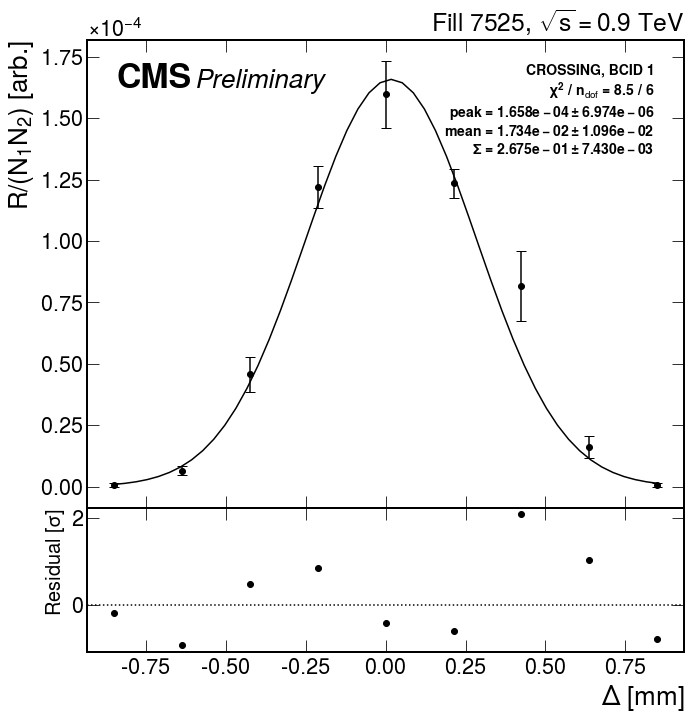


0it [00:00, ?it/s]                   


ValueError: No figure None

In [9]:
    data.to_csv(f'{outpath}/{luminometer}_data.csv', index=False)
    if pdf: # Initialize template for plots
        pdf = PdfPages(f'{outpath}/{luminometer}_fit.pdf')
        fig = plt.figure()
        ax1 = fig.add_axes((.12,.3,.83,.65)) # Upper part: fit and data points
        hep.cms.label(llabel="Preliminary", rlabel=fr"Fill {general_info.fillnum[0]}, $\sqrt{{s}}={general_info['energy'][0]*2/1000:.1f}$ TeV", loc=1)
        ax1.set_ylabel('$R/(N_1 N_2)$ [arb.]')
        ax1.set_xticklabels([])
        ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True, useOffset=False)
        ax1.minorticks_off()
        ax2 = fig.add_axes((.12,.1,.83,.2)) # Lower part: residuals
        ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
        ax2.set_ylabel(r'Residual [$\sigma$]',fontsize=20)
        ax2.set_xlabel(r'$\Delta$ [mm]')
        ax2.minorticks_off()

    # Make a fit for each BCID in both planes
    fit_results = pd.DataFrame()
    for p, plane in tqdm(enumerate(data.plane.unique())): # For each plane
        for bcid in tqdm(collidable+1, leave=False): # For each BCID
            data_x = scan[scan.nominal_sep_plane == plane]['sep']
            data_y = data[(data.plane == plane) & (data.bcid == bcid)]['rate_normalised']
            data_y_err = data[(data.plane == plane) & (data.bcid == bcid)]['rate_normalised_err']
            least_squares = LeastSquares(data_x, data_y, data_y_err, FIT_FUNCTIONS[fit]['handle']) # Initialise minimiser with data and fit function of choice
            m = Minuit(least_squares, **FIT_FUNCTIONS[fit]['initial_values']) # Give the initial values defined in "FIT_FUNCTIONS"
            m.migrad()  # Finds minimum of least_squares function
            m.hesse()   # Accurately computes uncertainties
            new = pd.DataFrame([m.values], columns=m.parameters) # Store values to dataframe
            new = pd.concat([new, pd.DataFrame([m.errors], columns=m.parameters).add_suffix('_err')], axis=1) # Add suffix "_err" to errors
            new['valid'] =  m.valid # Fit status
            new['accurate'] = m.accurate
            new.insert(0, 'bcid', bcid)
            new.insert(0, 'plane', plane)
            fit_results = pd.concat([fit_results, new], ignore_index=True)
            if pdf: # This is just for plotting
                figure_items = []
                figure_items.append(ax1.errorbar(data_x, data_y, data_y_err, fmt='ko', capsize=5)) # Plot the data points
                x_dense = np.linspace(np.min(data_x), np.max(data_x))
                figure_items.append(ax1.plot(x_dense, FIT_FUNCTIONS[fit]['handle'](x_dense, *m.values), 'k')) # Plot the fit result
                fit_info = [f'{plane}, BCID {bcid}', f'$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}']
                for param, v, e in zip(m.parameters, m.values, m.errors):
                    fit_info.append(f'{param} = ${v:.3e} \\pm {e:.3e}$')
                fit_info = [info.replace('cap_sigma', r'$\Sigma$') for info in fit_info]
                figure_items.append(ax1.text(0.95, 0.95, '\n'.join(fit_info), transform=ax1.transAxes, fontsize=14, fontweight='bold',
                    verticalalignment='top', horizontalalignment='right'))
                residuals = (data_y.to_numpy() - FIT_FUNCTIONS[fit]['handle'](data_x, *m.values).to_numpy()) / data_y_err.to_numpy()
                figure_items.append(ax2.scatter(data_x, residuals, c='k'))
                lim = list(plt.xlim()) # Plot wide line without changing xlim
                figure_items.append(ax2.plot(lim, [0, 0], 'k:'))
                plt.xlim(lim)
                plt.show()
                pdf.savefig()
                for item in figure_items: # Only delete lines and fit results, leave general things
                    if isinstance(item, list):
                        item[0].remove()
                    else:
                        item.remove()
    if pdf:
        pdf.close()
    fit_results.cap_sigma *= 1e3 # to µm
    print('\nfit_results:')
    print(fit_results.head())
    fit_results.to_csv(f'{outpath}/{luminometer}_fit_results.csv', index=False)
    val = fit_results.pivot(index='bcid', columns=['plane'], values=['cap_sigma', 'peak', 'cap_sigma_err', 'peak_err'])
    sigvis = np.pi * val.cap_sigma.prod(axis=1) * val.peak.sum(axis=1) # sigvis = 2*pi*Sigma_x*Sigma_y*(peak_1+peak_2)/2
    sigvis_err = (val.cap_sigma_err**2 / val.cap_sigma**2).sum(axis=1) + (val.peak_err**2).sum(axis=1) / (val.peak).sum(axis=1)**2 # Propagation of uncertainty
    sigvis_err = np.sqrt(sigvis_err) * sigvis
    lumi = pd.concat([sigvis, sigvis_err], axis=1)
    lumi.columns = ['sigvis', 'sigvis_err']
    print('\nlumi:')
    print(lumi.head())
    lumi.to_csv(f'{outpath}/{luminometer}_lumi.csv')